<font size="6"> **Portfolio Optimization** </font>

$$ \vec{r}(N,T) = \vec{\beta}(N,K) · \vec{f}(K,T) + \vec{s}(N,T)$$

* from $\vec{f}$ compute `factor covariance matrix`: $\vec{F}$
* from $\vec{s}$ compute `idiosyncratic covariance matrix` $\vec{S}$ and extract diagonal

Use  $\vec{\beta}$, $\vec{F}$ and $\vec{S}$ to estimate portfolio risk: $\sigma_{r_{p}}$

In [1]:
%%capture
%run 01_portopt_data.ipynb

In [2]:
import matplotlib.pyplot as plt
import scipy
import pickle
import datetime as dt

from mle_quant_utils import portopt_utils
from tqdm import tqdm

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

In [3]:
import yaml
import os

# Retrieve parameters from configuration file
with open("../conf.yml", "r") as ymlfile:
    cfg = yaml.load(ymlfile)

In [4]:
RND_SEED = 123
STR_DATE_FMT = "%Y%m%d"

universe_start_date = test_dates[0]
universe_end_date = test_dates[-1]
min_mkt_cap = float(cfg['backtesting']['min_mkt_cap'])
risk_aversion = float(cfg['backtesting']['risk_aversion'])


In [5]:
daily_returns = daily_returns[universe_start_date:universe_end_date].copy()
pd.concat([daily_returns.head(2), daily_returns.tail(2)],axis=0)

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,XL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2015-05-28 00:00:00+00:00,-0.004683,-0.006383,-0.005534,-0.002000,0.001341,-0.004308,0.005088,0.001448,-0.001809,0.000284,...,-0.004758,0.002820,0.000000,0.005400,0.006105,0.005479,-0.001949,-0.007701,-0.004797,-0.006864
2015-05-29 00:00:00+00:00,-0.012719,0.009538,-0.020019,-0.011390,-0.013042,-0.004782,-0.013383,-0.008980,-0.011560,-0.005119,...,0.001594,-0.007940,0.001050,-0.002207,-0.006944,-0.003519,-0.018412,0.006169,-0.008223,0.013427
2015-12-24 00:00:00+00:00,-0.003682,0.012022,0.000465,-0.005341,-0.002041,0.000090,0.000000,-0.001820,-0.004224,0.005673,...,0.009623,-0.000620,-0.010724,-0.002127,0.005553,-0.001614,-0.001620,0.001364,0.003975,0.003121
2015-12-28 00:00:00+00:00,0.007040,-0.013259,0.009526,-0.011204,0.004953,0.002309,-0.001550,-0.001441,-0.001060,-0.006164,...,0.000503,-0.001064,-0.007439,0.004930,-0.021138,-0.003484,-0.002177,-0.006413,-0.005033,-0.004784


In [6]:
def get_obj_func(h0, risk_aversion, Q, specVar, alpha_vec, Lambda): 
    def obj_func(h):
        _h0 = h0.values
        factor_risk = 0.5*risk_aversion*np.sum( np.matmul(Q,h)**2 )
        idiosyncratic_risk = 0.5*risk_aversion*np.dot(h**2, specVar)  # specVar is diag
        exp_port_ret = np.dot(h, alpha_vec)
        trans_costs = np.dot((h-_h0)**2, Lambda)
        obj_f = factor_risk + idiosyncratic_risk - exp_port_ret + trans_costs
        return(obj_f)
    
    return obj_func

In [7]:
def get_grad_func(h0, risk_aversion, Q, QT, specVar, alpha_vec, Lambda):
    def grad_func(h):
        
        grad_factor_risk = risk_aversion*np.matmul(QT, np.matmul(Q,h))
        grad_idiosyncratic_risk = risk_aversion*specVar*h
        grad_exp_port_ret =  alpha_vec
        grad_trans_costs = 2*(h-h0)*Lambda
        
        g = grad_factor_risk + grad_idiosyncratic_risk - grad_exp_port_ret + grad_trans_costs
        return(np.asarray(g))
    
    return grad_func

In [8]:
def get_h_star(risk_aversion, Q, QT, specVar, alpha_vec, h0, Lambda):
    """
    Optimize the objective function

    Parameters
    ----------        
    risk_aversion : int or float 
        Trader's risk aversion
        
    Q : patsy.design_info.DesignMatrix 
        Q Matrix
        
    QT : patsy.design_info.DesignMatrix 
        Transpose of the Q Matrix
        
    specVar: Pandas Series 
        Specific Variance
        
    alpha_vec: patsy.design_info.DesignMatrix 
        alpha vector
        
    h0 : Pandas Series  
        initial holdings
        
    Lambda : Pandas Series  
        Lambda
        
    Returns
    -------
    optimizer_result[0]: Numpy ndarray 
        optimized holdings
    """
    obj_func = get_obj_func(h0, risk_aversion, Q, specVar, alpha_vec, Lambda)
    grad_func = get_grad_func(h0, risk_aversion, Q, QT, specVar, alpha_vec, Lambda)


    optimizer_result = scipy.optimize.fmin_l_bfgs_b(
        func=obj_func, x0=h0, fprime=grad_func
    )
    return optimizer_result[0]

In [9]:
risk_model.keys()

dict_keys(['factor_betas', 'factor_var_vector', 'factor_returns', 'idiosyncratic_var_vector'])

In [10]:
risk_facret = risk_model['factor_returns']
#alpha_facret

In [11]:
B = risk_model['factor_betas']
B.shape

(490, 20)

In [12]:
Fvar = np.diag(risk_model['factor_var_vector'].values[:,0])
Fvar.shape

(20, 20)

In [13]:
ml_alpha_rank = ml_alpha.groupby(level=0).apply(
    lambda grp: pd.cut(grp, bins=np.linspace(start=grp.min(), stop=grp.max(), num=11), labels=False, include_lowest=True))
#ml_alpha_rank = ml_alpha.groupby(level=0).transform(lambda x: scipy.stats.rankdata(x))
mu = ml_alpha_rank.groupby(level=0).transform(np.mean)
std = ml_alpha_rank.groupby(level=0).transform(np.std)
ml_alpha_rank_zscore = (ml_alpha_rank - mu)/std

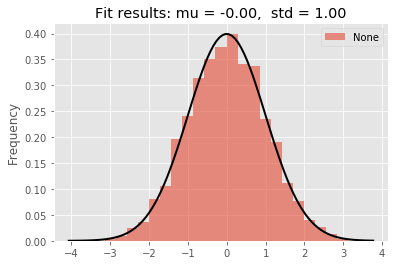

In [14]:
# Fit a normal distribution to the data:
mu, std = scipy.stats.norm.fit(ml_alpha_rank_zscore)

# Plot the histogram.
ml_alpha_rank_zscore.plot.hist(bins=25, density=True, alpha=0.6)

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p =  scipy.stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)
plt.legend()
plt.show()

In [15]:
ml_alpha_rank.xs(level=0, key=universe_start_date).describe()

count    485.000000
mean       4.876289
std        1.675404
min        0.000000
25%        4.000000
50%        5.000000
75%        6.000000
max        9.000000
dtype: float64

In [16]:
# alphas
alpha_factors = ['Mean_Reversion_Sector_Neutral_Smoothed', 'Momentum_1YR_Smoothed',
       'Overnight_Sentiment_Smoothed']
B_alpha = features_df[alpha_factors].copy()
B_alpha['ML_FACTOR'] = ml_alpha
B_alpha['ML_FACTOR_RZ'] = ml_alpha_rank_zscore
B_alpha['COMBI_FACTOR'] = B_alpha[alpha_factors].mean(axis=1)

In [17]:
test_alphas = B_alpha.loc[(test_dates, slice(None)), ['ML_FACTOR', 'ML_FACTOR_RZ','COMBI_FACTOR', 'Momentum_1YR_Smoothed']]
test_alphas.describe().T

,count,mean,std,min,25%,50%,75%,max
ML_FACTOR,72685.0,9.505026e-03,0.009540,-0.006877,0.003090,0.007066,0.013481,0.037049
ML_FACTOR_RZ,72685.0,2.016227e-19,0.998981,-3.361165,-0.701219,-0.032392,0.692174,3.411370
COMBI_FACTOR,72685.0,-2.336870e-03,0.511739,-1.711771,-0.358187,-0.003912,0.354386,1.706674
Momentum_1YR_Smoothed,72685.0,-7.505632e-03,0.994504,-1.728439,-0.860603,-0.021696,0.853371,1.728439


In [18]:
test_alphas.corr()

,ML_FACTOR,ML_FACTOR_RZ,COMBI_FACTOR,Momentum_1YR_Smoothed
ML_FACTOR,1.000000,0.116332,0.047137,-0.002370
ML_FACTOR_RZ,0.116332,1.000000,0.392648,-0.014870
COMBI_FACTOR,0.047137,0.392648,1.000000,0.590506
Momentum_1YR_Smoothed,-0.002370,-0.014870,0.590506,1.000000


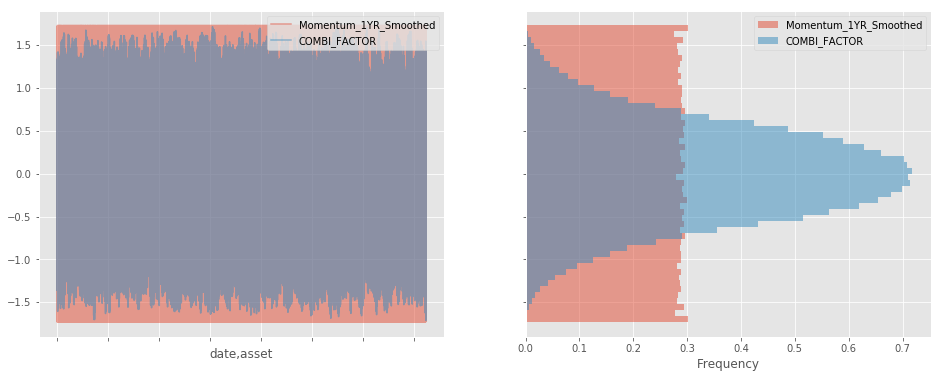

In [19]:
fig, axs = plt.subplots(1,2, figsize=(16,6), sharey=True)
ax1, ax2 = axs
B_alpha[['Momentum_1YR_Smoothed', 'COMBI_FACTOR']].plot(ax=ax1, alpha=0.5)
B_alpha[['Momentum_1YR_Smoothed', 'COMBI_FACTOR']].plot.hist(ax=ax2, bins=50, alpha=0.5, density=True, orientation='horizontal')
plt.show()

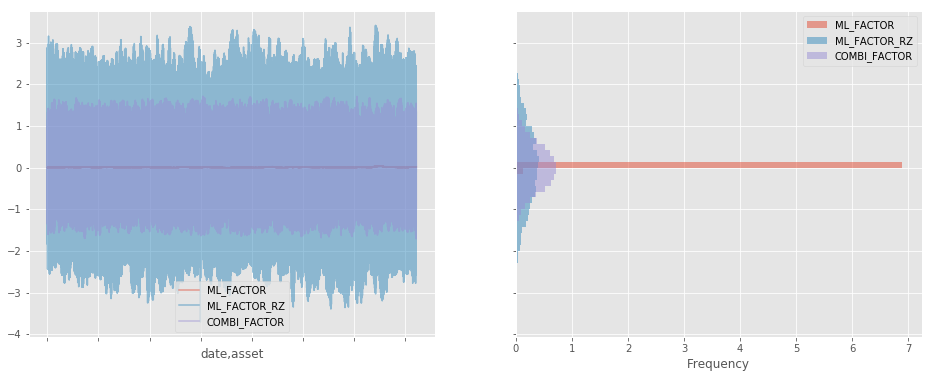

In [20]:
fig, axs = plt.subplots(1,2, figsize=(16,6), sharey=True)
ax1, ax2 = axs

B_alpha[['ML_FACTOR', 'ML_FACTOR_RZ', 'COMBI_FACTOR']].plot(ax=ax1, alpha=0.5)
B_alpha[['ML_FACTOR', 'ML_FACTOR_RZ', 'COMBI_FACTOR']].plot.hist(ax=ax2, bins=50, alpha=0.5, density=True, orientation='horizontal')

plt.show()

In [21]:
B_alpha[['ML_FACTOR', 'ML_FACTOR_RZ', 'COMBI_FACTOR']].isna().sum()

ML_FACTOR       0
ML_FACTOR_RZ    0
COMBI_FACTOR    0
dtype: int64

In [22]:
alpha_vec = B_alpha['ML_FACTOR_RZ'].copy()

In [23]:
previous_holdings = pd.DataFrame(data = {"asset" : ["A"], "h.opt.previous" : np.array(0)}).set_index('asset')
previous_holdings

,h.opt.previous
asset,
A,0


In [24]:
def get_universe(adv, min_adv, h_prev, dt_idx):
    universe = adv.loc[dt_idx] > min_adv
    universe = universe[universe]
    universe = universe.index.union(h_prev.index)
    universe.name = 'asset'
    return universe
    

In [25]:
len(set(alpha_vec.index.get_level_values(1).unique()).intersection(set(universe_tickers)))

490

In [26]:
len(universe_tickers)

490

In [27]:
# data alignment: static frame
bkt_dates = mkt_cap.loc[universe_start_date:universe_end_date].index

mkt_caps = {}
betas_exp = {}
alphas_vec = {}
# factor_cov = {}
spec_var = {}
lambdas = {}

for dt_idx in bkt_dates:
    dt_idx_str = dt.datetime.strftime(dt_idx, STR_DATE_FMT)
    universe = pd.Index(universe_tickers)
    betas_exp[dt_idx_str] = B.loc[universe]
    spec_var[dt_idx_str] = risk_model['idiosyncratic_var_vector'].loc[universe, '0']
    alphas_vec[dt_idx_str] = alpha_vec.loc[dt_idx][universe]*1e-4
    lambdas[dt_idx_str] = 0.1 / adv.loc[dt_idx, universe]
    lambdas[dt_idx_str] = lambdas[dt_idx_str].fillna(lambdas[dt_idx_str].median())

In [28]:
example_dt = dt.datetime.strftime(universe_start_date, STR_DATE_FMT)

# universe
ex_universe = pd.Index(['AMZN', 'MSFT', 'AAPL', 'GOOG'])
ex_universe.name = 'asset'
# alpha
current_alpha_vec = alphas_vec[example_dt].loc[ex_universe]
# risk
BT = betas_exp[example_dt].loc[ex_universe].T
Q = np.matmul(scipy.linalg.sqrtm(Fvar), BT)
QT = Q.transpose()
specVar = spec_var[example_dt].loc[ex_universe]
# cost
Lambda = lambdas[example_dt].loc[ex_universe]
# previous holidng
h0 = pd.Series(index=current_alpha_vec.index, data=np.zeros(len(current_alpha_vec)))

In [29]:
BT.shape, Q.shape, specVar.shape

((20, 4), (20, 4), (4,))

In [30]:
B_alpha.loc[(universe_start_date, ['AMZN', 'MSFT', 'AAPL', 'GOOG']), :]

Mean_Reversion_Sector_Neutral_Smoothed  \
date                      asset                                           
2015-05-28 00:00:00+00:00 AAPL                                -1.296340   
                          AMZN                                -0.662574   
                          GOOG                                -1.163105   
                          MSFT                                 1.512397   

                                 Momentum_1YR_Smoothed  \
date                      asset                          
2015-05-28 00:00:00+00:00 AAPL                1.524645   
                          AMZN                1.262653   
                          GOOG               -1.528283   
                          MSFT               -0.025471   

                                 Overnight_Sentiment_Smoothed  ML_FACTOR  \
date                      asset                                            
2015-05-28 00:00:00+00:00 AAPL                       1.321361   0.001930   
                          AMZN                       0.392837   0.001770   
                          GOOG                      -0.135707  -0.002308   
                          MSFT                      -1.585633   0.002217   

                                 ML_FACTOR_RZ  COMBI_FACTOR  
date                      asset                              
2015-05-28 00:00:00+00:00 AAPL       0.670711      0.516555  
                          AMZN       0.670711      0.330972  
                          GOOG      -2.910515     -0.942365  
                          MSFT       0.670711     -0.032903

In [31]:
h_star = get_h_star(risk_aversion, Q, QT, specVar, current_alpha_vec, h0, Lambda)
h_star[:5]

array([  618.06625877,   864.80816365,   819.22933988, -3384.39927802])

In [32]:
h_star.sum()

-1082.29551571123

In [33]:
def get_total_transaction_costs(h0, h_star, Lambda):
    """
    Calculate Total Transaction Costs

    Parameters
    ----------
    h0 : Pandas Series
        initial holdings (before optimization)
        
    h_star: Numpy ndarray 
        optimized holdings
        
    Lambda : Pandas Series  
        Lambda
        
    Returns
    -------
    total_transaction_costs : float
        Total Transaction Costs
    """
    
    return np.dot(Lambda, (h_star-h0)**2)

In [34]:
total_transaction_costs = get_total_transaction_costs(h0, h_star, Lambda)
total_transaction_costs

0.0012366475728485323

In [35]:
def get_risk_exposures(BT, h_star):
    """
    Calculate portfolio's Risk Exposure

    Parameters
    ----------
    B : patsy.design_info.DesignMatrix 
        Matrix of Risk Factors
        
    BT : patsy.design_info.DesignMatrix 
        Transpose of Matrix of Risk Factors
        
    h_star: Numpy ndarray 
        optimized holdings
        
    Returns
    -------
    risk_exposures : Pandas Series
        Risk Exposures
    """
    factor_names = BT.index
    risk_exposures = np.dot(BT, h_star)
    return pd.Series(index=factor_names, data=risk_exposures)



In [36]:
risk_exposures = get_risk_exposures(BT, h_star)
risk_exposures[:5]

0   -63.345310
1   -21.026938
2   -20.913354
3   -16.078836
4   -57.092781
dtype: float64

In [37]:
def get_portfolio_alpha_exposure(B_alpha, h_star):
    """
    Calculate portfolio's Alpha Exposure

    Parameters
    ----------
    B_alpha : patsy.design_info.DesignMatrix 
        Matrix of Alpha Factors
        
    h_star: Numpy ndarray 
        optimized holdings
        
    Returns
    -------
    alpha_exposures : Pandas Series
        Alpha Exposures
    """
    if isinstance(B_alpha, pd.Series):
        alpha_factor_names = [B_alpha.name]
    elif isinstance(B_alpha, pd.DataFrame):
        alpha_factor_names = B_alpha.columns
    else:
        alpha_factor_names = range(0,B_alpha.shape[1])
    return pd.Series(np.matmul(B_alpha.transpose(), h_star), index=alpha_factor_names)
    

In [38]:
portfolio_alpha_exposure = get_portfolio_alpha_exposure(current_alpha_vec, h_star)
portfolio_alpha_exposure[:5]

ML_FACTOR_RZ    1.139439
dtype: float64

In [39]:
def form_optimal_portfolio(universe, previous_holdings, risk_aversion, Fvar, betas_exp, alphas_vec, spec_var, lambdas, dt_idx):
    dt_idx_str = dt.datetime.strftime(dt_idx, STR_DATE_FMT)
    
    #universe = pd.Index(['AMZN', 'MSFT', 'AAPL', 'GOOG'])
    #universe.name = 'asset'
    universe_s = pd.DataFrame(index=universe, data= np.zeros(len(universe)), columns=['universe'])
    h_prev = universe_s.join(previous_holdings, how='outer').fillna(0.0)['h.opt.previous']
    
    # Beta exposures
    B = betas_exp[dt_idx_str].loc[universe]
    BT = B.transpose()
    # Factor covariance matrix
    # Fvar as argument
    # Specific variance
    specVar = spec_var[dt_idx_str].loc[universe]
    # Transaction costs
    Lambda = lambdas[dt_idx_str].loc[universe]
    # alpha factor
    alpha_vec = alphas_vec[dt_idx_str].loc[universe]
    Q = np.matmul(scipy.linalg.sqrtm(Fvar), BT)
    QT = Q.transpose()
    #print(universe.shape, BT.shape, Fvar.shape, specVar.shape, alpha_vec.shape, Lambda.shape)
    #print(alpha_vec.isna().sum())
    alpha_vec = alpha_vec.fillna(alpha_vec.median())
    Lambda = Lambda.fillna(Lambda.median())
    nans = alpha_vec.isna()
    if any(nans):
        print(dt_idx_str)
        print(nans.sum())
        print(alpha_vec[nans])
    h_star = get_h_star(risk_aversion, Q, QT, specVar, alpha_vec, h_prev, Lambda)


    opt_portfolio = pd.DataFrame(data = {"asset" : universe, "h.opt" : h_star}).set_index('asset')
    
    risk_exposures = get_risk_exposures(BT, h_star)
    portfolio_alpha_exposure = get_portfolio_alpha_exposure(alpha_vec, h_star)
    total_transaction_costs = get_total_transaction_costs(h_prev, h_star, Lambda)
    
    result = {
        "opt.portfolio" : opt_portfolio, 
        "risk.exposures" : risk_exposures, 
        "alpha.exposures" : portfolio_alpha_exposure,
        "total.cost" : total_transaction_costs}
    return result

In [40]:
def convert_to_previous(result): 
    prev = result['opt.portfolio']
    prev = prev.rename(index=str, columns={"h.opt": "h.opt.previous"}, copy=True, inplace=False)
    return prev

In [41]:
def build_tradelist(prev_holdings, opt_result):
    tmp = opt_result['opt.portfolio'].join(prev_holdings, how='outer')
    tmp['h.opt.previous'] = np.nan_to_num(tmp['h.opt.previous'])
    tmp['h.opt'] = np.nan_to_num(tmp['h.opt'])
    return tmp

In [42]:
trades = {}
port = {}

bkt_dates = mkt_cap.loc[universe_start_date:universe_end_date].index
previous_holdings = h0
previous_holdings.name = 'h.opt.previous'

for dt_idx in tqdm(bkt_dates, desc='Optimizing Portfolio', unit='day'):
    dt_idx_str = dt.datetime.strftime(dt_idx, STR_DATE_FMT)
    universe = get_universe(mkt_cap, min_mkt_cap, previous_holdings, dt_idx)
    result = form_optimal_portfolio(universe, previous_holdings,  risk_aversion, Fvar, betas_exp, alphas_vec, spec_var, lambdas, dt_idx)
    trades[dt_idx_str] = build_tradelist(previous_holdings, result)
    port[dt_idx_str] = result
    previous_holdings = convert_to_previous(result)

Optimizing Portfolio: 100%|██████████| 149/149 [00:09<00:00, 16.30day/s]


In [43]:
# Fix NaNs

In [44]:
result.keys()

dict_keys(['total.cost', 'alpha.exposures', 'opt.portfolio', 'risk.exposures'])

In [45]:
port['20151028']['opt.portfolio'].sample(5)

,h.opt
asset,
ILMN,-947.857355
ADBE,742.969812
WYN,-3523.590848
DLR,-5432.293313
UNH,4131.344737


In [46]:
alpha_facret = pd.read_csv(INPATH_ALPHA + INFILE3, parse_dates=['date'])
alpha_facret['date'] = alpha_facret['date'].dt.tz_localize('utc')
alpha_facret.set_index('date', inplace=True)
alpha_facret[:2]

,Mean_Reversion_Sector_Neutral_Smoothed,Overnight_Sentiment_Smoothed,ML_FACTOR,Momentum_1YR_Smoothed
date,,,,
2015-05-28 00:00:00+00:00,0.000753,0.001902,0.005999,-0.001104
2015-05-29 00:00:00+00:00,-0.000807,0.000579,0.005643,-0.001996


In [47]:
daily_returns.loc['2015-10-28'].head()

A      -0.003908
AAL    -0.012905
AAP     0.005226
AAPL    0.041206
ABBV    0.012933
Name: 2015-10-28 00:00:00+00:00, dtype: float64

In [48]:
port['20151028']['opt.portfolio'].head()

,h.opt
asset,
A,4686.432751
AAL,-3315.385159
AAP,1036.072153
AAPL,-1098.692753
ABBV,3027.199075


In [49]:
## assumes v, w are pandas Series 
def partial_dot_product(v, w):
    common = v.index.intersection(w.index)
    return np.sum(v[common] * w[common])

def build_pnl_attribution(): 
    wins_ret = 0.5
    df = pd.DataFrame(index = bkt_dates)
    # Static factor returns
    risk_fr = risk_model['factor_returns']
    #alpha_fr = alpha_facret
        
    for dt_idx in bkt_dates:
        dt_idx_str = dt.datetime.strftime(dt_idx, STR_DATE_FMT)
        p = port[dt_idx_str]
        wins_returns = np.clip(daily_returns.loc[dt_idx],-wins_ret,wins_ret).to_frame('DlyReturn')
        mf = p['opt.portfolio'].join(wins_returns, how = 'left')
        df.at[dt_idx,"daily.pnl"] = partial_dot_product(mf['h.opt'], mf['DlyReturn'] )
        
        #df.at[dt_idx,"attribution.alpha.pnl"] = partial_dot_product(alpha_fr, p['alpha.exposures'])
        #df.at[dt_idx,"attribution.risk.pnl"] = partial_dot_product(risk_fr, p['risk.exposures'])
        df.at[dt_idx,"attribution.cost"] = p['total.cost']
        
    return df

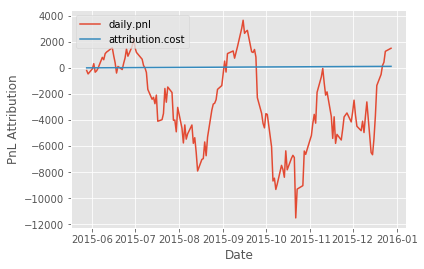

In [50]:
attr = build_pnl_attribution()

for column in attr.columns:
        plt.plot(attr[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('PnL Attribution')
plt.show()